# <font color = lightcoral>Setting Random Seed
>    
### <font color = red> Non-Overlapping Windows

> Running 4 Models for Comparison

## <font color = grey> Admin

In [1]:
import pandas as pd
import os
import gzip
import time
import warnings
import os
import shutil
from datetime import datetime
# Set display option to show the full length of the column
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

# Determine the base directory based on the effective user ID
if os.geteuid() == 0:  # root user
    base_dir = '/root'
else:
    base_dir = '/home/sagemaker-user'

# Set the environment variable
os.environ['BASE_DIR'] = base_dir

# Verify the base directory
print(f"Base directory set to: {base_dir}")

Base directory set to: /home/sagemaker-user


# <font color = tomato> Common

In [2]:
################################### Parameters and Hyperparameters ################################

# Parameters and Hyperparameters
data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/01.Full_Base/'
input_file = f"{data_dir}/20240704__full__new_features_v1.10.parquet"
output_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/02.Full_Train_Test'

max_events = 10
input_length = 10
gap = 1
prediction_period = 1
test_size = 0.2
shuffle = False

hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 50
batch_size = 16
learning_rate = 0.001
dropout = 0.3  # Adding dropout to prevent overfitting

# Set random seed for reproducibility
random_seed = 42

print("Parameters and Hyperparameters Set")
print("*"*100 + "\n")

################################### Data Preprocessing ################################

# Data Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Load the data
df = pd.read_parquet(input_file)

# Select derived features and a subset of EventID columns
selected_columns = ['time_start_int', 'Class', 'unique_events', 'most_frequent_event', 'transitions', 'entropy']
event_id_columns = [col for col in df.columns if col.startswith('EventId_')]

# Replace -1 values with 0
df[event_id_columns].replace(-1, 0, inplace=True)

# Scale numerical features
scaler = StandardScaler()
numerical_features = ['unique_events', 'transitions', 'entropy']
df[selected_columns[2:]] = scaler.fit_transform(df[selected_columns[2:]])

# Encode categorical features
label_encoder = LabelEncoder()
df['most_frequent_event'] = label_encoder.fit_transform(df['most_frequent_event'])

# Apply PCA to EventID columns to reduce them to 50 features
pca = PCA(n_components=max_events)
event_id_pca = pca.fit_transform(df[event_id_columns])

# Create a new DataFrame with the reduced EventID features
event_id_pca_df = pd.DataFrame(event_id_pca, columns=[f'EventId_PCA_{i+1}' for i in range(max_events)])

# Combine the reduced EventID features with the selected columns
df_reduced = pd.concat([df[selected_columns], event_id_pca_df], axis=1)

print("Data Preprocessed")
print("*"*100 + "\n")

################################### Create Sequences ################################

# Function to create non-overlapping sequences
def create_sequences(data, time_index_col, feature_cols, target_col, input_length=input_length, gap=1, prediction_period=1):
    sequences = []
    targets = []
    
    start_idx = 0
    while start_idx + input_length + gap + prediction_period <= len(data):
        end_idx = start_idx + input_length
        sequence = data[feature_cols].iloc[start_idx:end_idx].values
        target = data[target_col].iloc[end_idx + gap:end_idx + gap + prediction_period].values[0]
        sequences.append(sequence)
        targets.append(target)
        start_idx = end_idx + gap + prediction_period  # Move to the next non-overlapping sequence
    
    return np.array(sequences), np.array(targets)

# feature_cols = selected_columns + selected_event_ids
feature_cols = [col for col in df_reduced.columns if col != 'Class']
target_col = 'Class'

X, y = create_sequences(df_reduced, 'time_start_int', feature_cols, target_col)

print("Created Sequences")
print("*"*100 + "\n")

################################### Split & SMOTE ################################

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle)

# Flatten X_train to 2D array for SMOTE
X_train = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Reshape X_train back to 3D array
X_train = X_train.reshape(-1, input_length, max_events + 5)

# Drop the first column from X_train and X_test
X_train = X_train[:, :, 1:]
X_test = X_test[:, :, 1:]

# Save the datasets
np.save(f'{output_dir}/X_train.npy', X_train)
np.save(f'{output_dir}/X_test.npy', X_test)
np.save(f'{output_dir}/y_train.npy', y_train)
np.save(f'{output_dir}/y_test.npy', y_test)

print("Split, SMOTE & Train/Test Saved")
print("*"*100 + "\n")

Parameters and Hyperparameters Set
****************************************************************************************************

Data Preprocessed
****************************************************************************************************

Created Sequences
****************************************************************************************************

Split, SMOTE & Train/Test Saved
****************************************************************************************************



___
# <font color = tomato> Models - Single Run

## <font color = grey> LSTM

---

In [3]:
# ################################### LSTM ################################

# # Define the LSTM model with Dropout
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
#         self.fc = nn.Linear(hidden_size, output_size)
    
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

# # Set random seeds for PyTorch
# torch.manual_seed(random_seed)
# torch.cuda.manual_seed(random_seed)
# np.random.seed(random_seed)

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# # Create DataLoader
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Initialize the model, loss function, and optimizer
# model = LSTMModel(max_events + 4, hidden_size, num_layers, output_size, dropout)
# criterion = nn.BCEWithLogitsLoss()  # For binary classification
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     for X_batch, y_batch in train_loader:
#         outputs = model(X_batch)
#         loss = criterion(outputs, y_batch)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
# print("Model Trained")
# print("*"*100 + "\n")

# ################################### Model Eval ################################

# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

# # Evaluate the model on the test set
# model.eval()
# with torch.no_grad():
#     test_outputs = model(X_test_tensor)
#     test_outputs = torch.sigmoid(test_outputs)  # Apply sigmoid to get probabilities
#     test_outputs = test_outputs.cpu().numpy()

#     # Convert y_test_tensor to NumPy array only if it is a tensor
#     if isinstance(y_test_tensor, torch.Tensor):
#         y_test_tensor = y_test_tensor.cpu().numpy()

#     test_preds = (test_outputs > 0.5).astype(int)  # Convert probabilities to binary predictions

# # Calculate evaluation metrics
# conf_matrix = confusion_matrix(y_test_tensor, test_preds)
# precision = precision_score(y_test_tensor, test_preds)
# recall = recall_score(y_test_tensor, test_preds)
# accuracy = accuracy_score(y_test_tensor, test_preds)
# f1 = f1_score(y_test_tensor, test_preds)

# print("Confusion Matrix:\n", conf_matrix)
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"F1 Score: {f1:.4f}")

# # Visualize the confusion matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

## <font color = grey> Single - Transformer Model

---

Epoch [1/50], Loss: 0.6863
Epoch [2/50], Loss: 0.7071
Epoch [3/50], Loss: 0.6819
Epoch [4/50], Loss: 0.6885
Epoch [5/50], Loss: 0.6001
Epoch [6/50], Loss: 0.7408
Epoch [7/50], Loss: 0.6923
Epoch [8/50], Loss: 0.8052
Epoch [9/50], Loss: 0.6916
Epoch [10/50], Loss: 0.6934
Epoch [11/50], Loss: 0.7007
Epoch [12/50], Loss: 0.6912
Epoch [13/50], Loss: 0.7161
Epoch [14/50], Loss: 0.7039
Epoch [15/50], Loss: 0.7213
Epoch [16/50], Loss: 0.6788
Epoch [17/50], Loss: 0.5484
Epoch [18/50], Loss: 0.7731
Epoch [19/50], Loss: 0.7098
Epoch [20/50], Loss: 0.7000
Epoch [21/50], Loss: 0.6901
Epoch [22/50], Loss: 0.7239
Epoch [23/50], Loss: 0.6866
Epoch [24/50], Loss: 0.7000
Epoch [25/50], Loss: 0.5511
Epoch [26/50], Loss: 0.7047
Epoch [27/50], Loss: 0.7415
Epoch [28/50], Loss: 0.6795
Epoch [29/50], Loss: 0.7260
Epoch [30/50], Loss: 0.6973
Epoch [31/50], Loss: 0.6896
Epoch [32/50], Loss: 0.6816
Epoch [33/50], Loss: 0.6388
Epoch [34/50], Loss: 0.7266
Epoch [35/50], Loss: 0.7069
Epoch [36/50], Loss: 0.6830
E

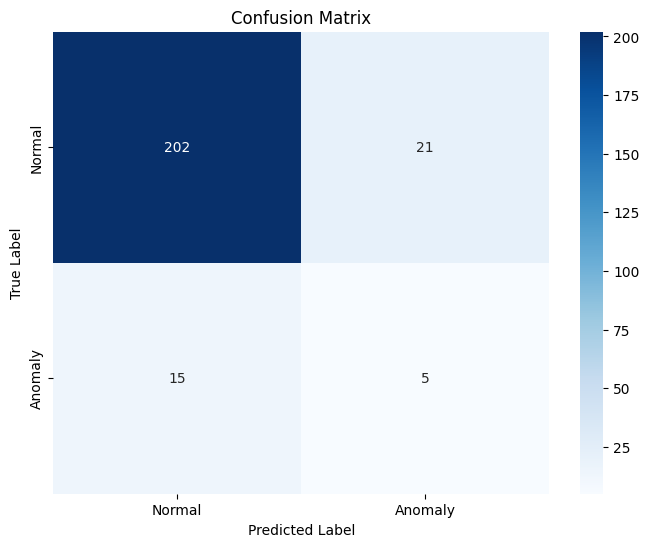

In [4]:
################################### Transformer ################################

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.pos_encoder = nn.Embedding(input_length, hidden_size)
        self.transformer = nn.Transformer(hidden_size, nhead=4, num_encoder_layers=num_layers, num_decoder_layers=num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        x = x + self.pos_encoder(positions)
        x = self.transformer(x, x)
        x = self.fc(x[:, -1, :])
        return x

# Set random seeds for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = TransformerModel(max_events + 4, hidden_size, num_layers, output_size, dropout)
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
print("Model Trained")
print("*"*100 + "\n")

################################### Model Eval ################################

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_outputs = torch.sigmoid(test_outputs)  # Apply sigmoid to get probabilities
    test_outputs = test_outputs.cpu().numpy()

    # Convert y_test_tensor to NumPy array only if it is a tensor
    if isinstance(y_test_tensor, torch.Tensor):
        y_test_tensor = y_test_tensor.cpu().numpy()

    test_preds = (test_outputs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test_tensor, test_preds)
precision = precision_score(y_test_tensor, test_preds)
recall = recall_score(y_test_tensor, test_preds)
accuracy = accuracy_score(y_test_tensor, test_preds)
f1 = f1_score(y_test_tensor, test_preds)

print("Confusion Matrix:\n", conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# <font color = tomato> For Later

## <font color = grey> Loop

In [5]:
# ################################### Parameters and Hyperparameters ################################

# # Parameters and Hyperparameters
# data_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/01.Full_Base/'
# input_file = f"{data_dir}/20240704__full__new_features_v1.10.parquet"
# output_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/10.20240705_StartOver_NewFeatures/02.Full_Train_Test'

# max_events_list = [10, 20]  # Different values to test
# input_length_list = [10, 20]  # Different values to test
# hidden_size_list = [64, 128]  # Different values to test
# dropout_list = [0.3, 0.5]  # Different values to test

# gap = 1
# prediction_period = 1
# test_size = 0.2
# shuffle = False

# num_layers = 2
# output_size = 1
# num_epochs = 50
# batch_size = 16
# learning_rate = 0.001

# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.decomposition import PCA
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# import matplotlib.pyplot as plt
# import seaborn as sns
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split

# # DataFrame to track results
# results_df = pd.DataFrame(columns=['Run', 'Precision', 'Recall', 'Accuracy', 'F1', 'TN', 'FP', 'FN', 'TP'])

# run_id = 0

# for max_events in max_events_list:
#     for input_length in input_length_list:
#         for hidden_size in hidden_size_list:
#             for dropout in dropout_list:
#                 run_id += 1
#                 print(f"Run {run_id}: max_events={max_events}, input_length={input_length}, hidden_size={hidden_size}, dropout={dropout}")
                
#                 ################################### Data Preprocessing ################################

#                 # Load the data
#                 df = pd.read_parquet(input_file)

#                 # Select derived features and a subset of EventID columns
#                 selected_columns = ['time_start_int', 'Class', 'unique_events', 'most_frequent_event', 'transitions', 'entropy']
#                 event_id_columns = [col for col in df.columns if col.startswith('EventId_')]

#                 # Replace -1 values with 0
#                 df[event_id_columns].replace(-1, 0, inplace=True)

#                 # Scale numerical features
#                 scaler = StandardScaler()
#                 numerical_features = ['unique_events', 'transitions', 'entropy']
#                 df[selected_columns[2:]] = scaler.fit_transform(df[selected_columns[2:]])

#                 # Encode categorical features
#                 label_encoder = LabelEncoder()
#                 df['most_frequent_event'] = label_encoder.fit_transform(df['most_frequent_event'])

#                 # Apply PCA to EventID columns to reduce them to 50 features
#                 pca = PCA(n_components=max_events)
#                 event_id_pca = pca.fit_transform(df[event_id_columns])

#                 # Create a new DataFrame with the reduced EventID features
#                 event_id_pca_df = pd.DataFrame(event_id_pca, columns=[f'EventId_PCA_{i+1}' for i in range(max_events)])

#                 # Combine the reduced EventID features with the selected columns
#                 df_reduced = pd.concat([df[selected_columns], event_id_pca_df], axis=1)

#                 ################################### Create Sequences ################################

#                 # Function to create non-overlapping sequences
#                 def create_sequences(data, time_index_col, feature_cols, target_col, input_length, gap=1, prediction_period=1):
#                     sequences = []
#                     targets = []
                    
#                     start_idx = 0
#                     while start_idx + input_length + gap + prediction_period <= len(data):
#                         end_idx = start_idx + input_length
#                         sequence = data[feature_cols].iloc[start_idx:end_idx].values
#                         target = data[target_col].iloc[end_idx + gap:end_idx + gap + prediction_period].values[0]
#                         sequences.append(sequence)
#                         targets.append(target)
#                         start_idx = end_idx + gap + prediction_period  # Move to the next non-overlapping sequence
                    
#                     return np.array(sequences), np.array(targets)

#                 # feature_cols = selected_columns + selected_event_ids
#                 feature_cols = [col for col in df_reduced.columns if col != 'Class']
#                 target_col = 'Class'

#                 X, y = create_sequences(df_reduced, 'time_start_int', feature_cols, target_col, input_length=input_length)

#                 ################################### Split & SMOTE ################################

#                 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle)

#                 # Flatten X_train to 2D array for SMOTE
#                 X_train = X_train.reshape(X_train.shape[0], -1)

#                 # Apply SMOTE
#                 smote = SMOTE(random_state=42)
#                 X_train, y_train = smote.fit_resample(X_train, y_train)

#                 # Reshape X_train back to 3D array
#                 X_train = X_train.reshape(-1, input_length, max_events + 5)

#                 # Drop the first column from X_train and X_test
#                 X_train = X_train[:, :, 1:]
#                 X_test = X_test[:, :, 1:]

#                 ################################### LSTM ################################

#                 # Define the LSTM model with Dropout
#                 class LSTMModel(nn.Module):
#                     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
#                         super(LSTMModel, self).__init__()
#                         self.hidden_size = hidden_size
#                         self.num_layers = num_layers
#                         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
#                         self.fc = nn.Linear(hidden_size, output_size)
                    
#                     def forward(self, x):
#                         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#                         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#                         out, _ = self.lstm(x, (h0, c0))
#                         out = self.fc(out[:, -1, :])
#                         return out

#                 # Convert data to PyTorch tensors
#                 X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
#                 y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
#                 X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#                 y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

#                 # Create DataLoader
#                 train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#                 train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#                 # Initialize the model, loss function, and optimizer
#                 model = LSTMModel(max_events + 4, hidden_size, num_layers, output_size, dropout)
#                 criterion = nn.BCEWithLogitsLoss()  # For binary classification
#                 optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#                 # Training loop
#                 for epoch in range(num_epochs):
#                     model.train()
#                     for X_batch, y_batch in train_loader:
#                         outputs = model(X_batch)
#                         loss = criterion(outputs, y_batch)
                        
#                         optimizer.zero_grad()
#                         loss.backward()
#                         optimizer.step()
                    
#                     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
                    
#                 ################################### Model Eval ################################

#                 # Evaluate the model on the test set
#                 model.eval()
#                 with torch.no_grad():
#                     test_outputs = model(X_test_tensor)
#                     test_outputs = torch.sigmoid(test_outputs)  # Apply sigmoid to get probabilities
#                     test_outputs = test_outputs.cpu().numpy()

#                     # Convert y_test_tensor to NumPy array only if it is a tensor
#                     if isinstance(y_test_tensor, torch.Tensor):
#                         y_test_tensor = y_test_tensor.cpu().numpy()

#                     test_preds = (test_outputs > 0.5).astype(int)  # Convert probabilities to binary predictions

#                 # Calculate evaluation metrics
#                 conf_matrix = confusion_matrix(y_test_tensor, test_preds)
#                 precision = precision_score(y_test_tensor, test_preds)
#                 recall = recall_score(y_test_tensor, test_preds)
#                 accuracy = accuracy_score(y_test_tensor, test_preds)
#                 f1 = f1_score(y_test_tensor, test_preds)
#                 tn, fp, fn, tp = conf_matrix.ravel()

#                 # Append results to DataFrame
#                 results_df = pd.concat([results_df, pd.DataFrame([{
#                     'Run': run_id,
#                     'Precision': precision,
#                     'Recall': recall,
#                     'Accuracy': accuracy,
#                     'F1': f1,
#                     'TN': tn,
#                     'FP': fp,
#                     'FN': fn,
#                     'TP': tp
#                 }])], ignore_index=True)

#                 print(f"Run {run_id} completed")
#                 print("*"*100 + "\n")

# ################################### Plot Results ################################

# # Plot the results
# fig, axes = plt.subplots(4, 2, figsize=(15, 20))
# fig.suptitle('Model Performance Metrics Over Different Runs')

# metrics = ['Precision', 'Recall', 'Accuracy', 'F1', 'TN', 'FP', 'FN', 'TP']
# for i, metric in enumerate(metrics):
#     ax = axes[i//2, i%2]
#     ax.plot(results_df['Run'], results_df[metric])
#     ax.set_title(metric)
#     ax.set_xlabel('Run')
#     ax.set_ylabel(metric)

# plt.tight_layout()
# plt.show()